# DATA 601 Project
    Domestic Movie Analysis from 1970-2023 – Have Domestic Films Gotten Worse?
    
#### By:
* Brian Englum
* Tyler Snow
* Joel Wheatley
* Manoj Kumar Pasupuleti

> **Purpose:**
> * Many movie fans and film critics believe that U.S. domestic movies have deteriorated in quality over time. Classic blockbusters like "The Godfather," "The Terminator," the Star Wars Episodes IV-VI seem to be a thing of the past. Studios and producers appear to be more interested in making animations; plot-absent, visually entertaining films; and never-ending sequels than making truly original, creative films.
> * Although viewers and critics may feel this way, little research has been done on the topic.
> * The goal of this project is to use statistical analysis and data science tools to explore this topic and come to a conclusion, one way or another.  

## First Steps
- Import necessary packages.
- Prevent warning messages.
- Create base DataFrame to work with.
  - Compiled movie data used can be found at the following address:<br>
  'https://raw.githubusercontent.com/tsnow2010/DATA601/refs/heads/main/DATA601_Project1/data/movie_data.csv'
  - For more information, please refer to the following README:<br>
  https://github.com/tsnow2010/DATA601/blob/main/DATA601_Project1/README.md


In [ ]:
# Imports
import pandas as pd
import csv
import numpy as np
import plotly.express as px
import plotly.subplots as sp
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [ ]:
# Prevent warning messages from appearing.
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Create initial DataFrame from movie_data.csv
df = pd.read_csv('https://raw.githubusercontent.com/tsnow2010/DATA601/refs/heads/main/DATA601_Project1/data/movie_data.csv')
print(f'This dataset has {df.shape[0]} movies.' )
df.sample(1)

This dataset has 51406 movies.


,Title,Year,Genre(s),IMDB,Rotten Tomatoes,Metacritic,TMDB,# of IMDB Votes,# of Awards,Gross Domestic Box Office Sales ($),Media,Directors,Origin
41998,The Long Goodbye,1973.0,"Comedy, Crime, Drama",7.5,95,87.0,7.41,"39,257",2 wins & 1 nomination,NaN,movie,Robert Altman,United States


## I: Data Cleaning

### Step 1) Restrict years used from 1970 to 2023.  Extreme outliers or no data exists for movies outside these ranges.

In [ ]:
df = df[(df['Year'] >= 1970.0) & (df['Year'] <= 2023.0)]

### Step 2) Remove '$' and ',' char's from the GDBOS column values and turns them into floats.

In [ ]:
df['Gross Domestic Box Office Sales ($)'] = df['Gross Domestic Box Office Sales ($)'].astype(str).apply(lambda x: ''.join([char for char in x if char not in ['$',',']])).astype(float)
df.sample(1)

,Title,Year,Genre(s),IMDB,Rotten Tomatoes,Metacritic,TMDB,# of IMDB Votes,# of Awards,Gross Domestic Box Office Sales ($),Media,Directors,Origin
42298,The Man Who Saved the World,2014.0,"Documentary, Biography, Drama",7.5,68,55.0,6.8,"2,626",8 wins & 7 nominations,NaN,movie,Peter Anthony,"Denmark, Latvia, Russia, United States"


### Step 3) Create a DataFrame (df) that allows data analysis of movie rating metrics.
- Change rating system values from str to float.
- Drop movies in the 1st Quartile of '# of IMDB Votes'
- Drop non-rating values from Rotten Tomatoes data.

In [ ]:
# Changes rating system values (EXCEPT RT) from str to float.
df['IMDB'] = df['IMDB'].astype(float)
df['Metacritic'] = df['Metacritic'].astype(float)
df['TMDB'] = df['TMDB'].astype(float)
df['Rotten_tom'] = pd.to_numeric(df['Rotten Tomatoes'], errors='coerce')
df['IMDB_votes'] = pd.to_numeric(df['# of IMDB Votes'].str.replace(',', ''), errors='coerce')

In [ ]:
# Removes movies in dataset contained in the 1st Quartile of '# of IMDB Votes'
votes_1st_qt = df['IMDB_votes'].describe()['25%']

print('This is the 1st Quartile of number of votes per movie:', votes_1st_qt)
print(f'Number of movies BEFORE removing movies with less than {votes_1st_qt} votes:', df.shape[0])

df = df[df['IMDB_votes'] >= votes_1st_qt]
print(f'Number of movies AFTER removing movies with less than {votes_1st_qt} votes:', df.shape[0],'\n')

This is the 1st Quartile of number of votes per movie: 814.25
Number of movies BEFORE removing movies with less than 814.25 votes: 42860
Number of movies AFTER removing movies with less than 814.25 votes: 26191 



In [ ]:
# Assigns 'None' to invalid RT ratings, i.e. '31/10' and etc, and removes them in df_movie_ratings.

def clean_rotten_tom(rtg):
    if type(rtg) is str:
        if '/' in rtg:
            return None
        else:
            return rtg
    else:
        return rtg

print("Number of movies BEFORE removing 'bad' RT ratings:", df.shape[0])

df['Rotten Tomatoes'] = df['Rotten Tomatoes'].apply(clean_rotten_tom)
df_RT = df.dropna(subset='Rotten Tomatoes')

print("Number of movies AFTER removing 'bad' RT ratings:", df_RT.shape[0])

df_RT['Rotten Tomatoes'] = df_RT['Rotten Tomatoes'].astype(float)

df = df.reset_index(drop=True)

df.sample(1)

Number of movies BEFORE removing 'bad' RT ratings: 26191
Number of movies AFTER removing 'bad' RT ratings: 16978


,Title,Year,Genre(s),IMDB,Rotten Tomatoes,Metacritic,TMDB,# of IMDB Votes,# of Awards,Gross Domestic Box Office Sales ($),Media,Directors,Origin,Rotten_tom,IMDB_votes
19466,The Beginning of Life,2016.0,"Documentary, Family",7.5,NaN,NaN,7.3,"1,020",1 nomination,NaN,movie,Estela Renner,Brazil,NaN,1020.0


### Step 4) Remove international movies.

In [ ]:
# Function determines whether a movie has 'United States' listed among the list of countries in 'Origin' cell.
def check_foreign(origin):
  try:
    if ('United States' in origin) or ('USA' in origin):
      return True
    else:
      return False
  except:
    return False

print("Number of movies BEFORE removing international movies or those with NaN values:", df.shape[0])

# Drop movies with NaN in "Origin"
df.dropna(subset='Origin')

# Check international status of movies.
df['Domestic?'] = df['Origin'].apply(check_foreign)

# Remove movies without "United States" in 'Origin'
df = df[df['Domestic?'] == True]

print("Number of movies AFTER removing international movies or those with NaN values:", df.shape[0])



Number of movies BEFORE removing international movies or those with NaN values: 26191
Number of movies AFTER removing international movies or those with NaN values: 16761


###Step 5) Create genre variables as individual binary variables for each genre.

In [ ]:
#Combine all the genres listed into a giant list then use set to get rid of all duplicates

df['Genre(s)'][pd.isna(df['Genre(s)'])] = ''
Genres = list(df['Genre(s)'])
Genres2 = []
for i in range(len(Genres)):
    Genres2.append(re.split(', ', Genres[i]))
flat_genres = [
    genres1
    for genres2 in Genres2
    for genres1 in genres2
]
set_genres = set(flat_genres)
all_genres = sorted(list(set_genres))
#all_genres.remove('')

In [ ]:
# Reset index so that loop will run
df = df.reset_index(drop=True)


# Make all genres individual columns (dummy variables) with binary True or False values
for i in all_genres:
    df[i] = False
    for j in range(len(df['Genre(s)'])):
        if i in df['Genre(s)'][j]:
            df[i][j] = True

In [ ]:
# Bar Graph of Genres
x=list()
for i in all_genres:
    x.append(df[i].sum())
GenreTable = pd.DataFrame({'Genre': all_genres, 'Freq': x})

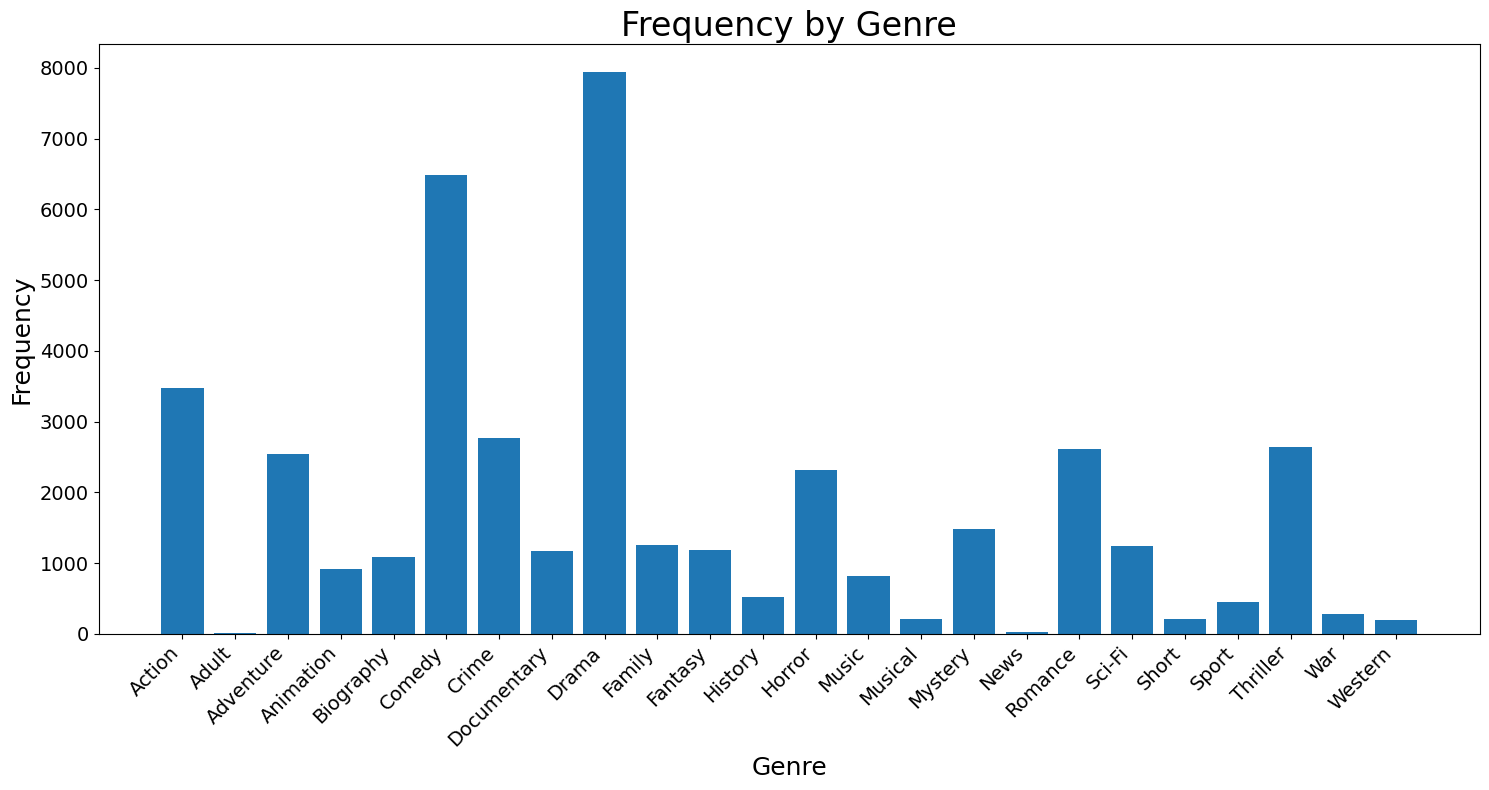

In [ ]:
plt.figure(figsize=(15, 8))
plt.bar(GenreTable.Genre, GenreTable.Freq)
plt.yticks(fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.title('Frequency by Genre', fontsize=24)
plt.xlabel('Genre', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tight_layout()
plt.savefig('bargraph_genre.jpg', format='jpg', dpi=300, bbox_inches='tight')

In [ ]:
#Combine Action/Adventure Genres into 'Action'
df['Action'][df['Adventure']==True] = True

#Combine Music/Muscial Genres into 'Music'
df['Music'][df['Musical']==True] = True

#Create 'Other Genre' from smaller genres
other_genres = ['Adult', 'News', 'Short', 'Sport', 'War', 'Western']
df['Other Genre'] = 0
for i in other_genres:
    df['Other Genre'][df[i]==True] = True

#Drop smaller genres
df = df.drop(columns=['Adventure', 'Adult', 'Musical', 'News', 'Short', 'Sport', 'War', 'Western'])

In [ ]:
#Remove column names for more compact bar graph
to_remove = ('Adventure', 'Adult', 'Musical', 'News', 'Short', 'Sport', 'War', 'Western')
all_genres = [genre for genre in all_genres if genre not in to_remove]
all_genres.append('Other Genre')

In [ ]:
#Bar Graph of Genres
x=list()
for i in all_genres:
    x.append(df[i].sum())
GenreTable = pd.DataFrame({'Genre': all_genres, 'Freq': x})

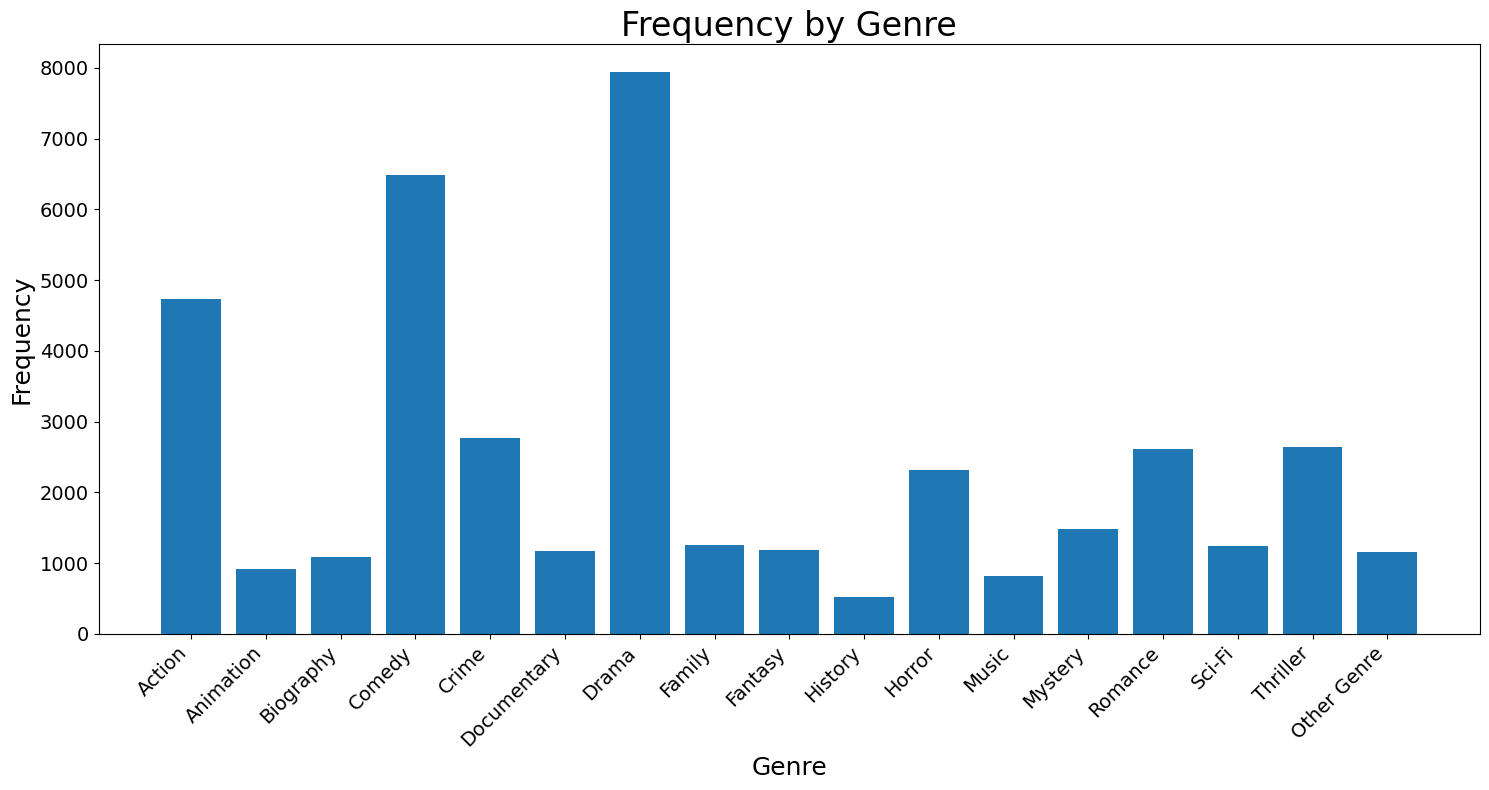

In [ ]:
plt.figure(figsize=(15, 8))
plt.bar(GenreTable.Genre, GenreTable.Freq)
plt.yticks(fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.title('Frequency by Genre', fontsize=24)
plt.xlabel('Genre', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.tight_layout()
plt.savefig('bargraph_genre.jpg', format='jpg', dpi=300, bbox_inches='tight')

### Step 6) Create a unique identifier with title (stripped down version) + film year to serve as identifier for merging data and removing duplicates

In [ ]:
#Convert year from float to string (remove NaN, then replace NaN)
df['Year_int'] = df['Year'].astype(str)
#remove ".0" from all years
df['Year_int'] = df['Year_int'].str.slice(0, -2)
#replace Nan
df['Year_int'][df['Year'].isnull()] = np.nan
#create composite variable
df['filmyear'] = df['Title'] + '_' + df['Year_int']

In [ ]:
#Create final identifier variable
#All lower case
df['filmyear2'] = df['filmyear'].str.lower()
#No spaces or special characters, just letters/numbers
df['filmyear2'] = df['filmyear2'].str.replace(r'[^A-Za-z0-9]', '', regex=True)

In [ ]:
#Identify duplicates
print('Number of duplicates: ', df['filmyear2'].duplicated().sum())
#See duplicates
df_dup = df[df['filmyear2'].isin(df['filmyear2'][df['filmyear2'].duplicated()==True])]
df_dup = df_dup.sort_values(by='filmyear2')
df_dup[['Title', 'Year', 'filmyear2']][0:20]

Number of duplicates:  255


,Title,Year,filmyear2
47,11-11-11,2011.0,1111112011
48,11/11/11,2011.0,1111112011
16,+1,2013.0,12013
22,1,2013.0,12013
112,2012,2009.0,20122009
113,2012,2009.0,20122009
151,3 Ninjas: Knuckle Up,1995.0,3ninjasknuckleup1995
149,3 Ninjas Knuckle Up,1995.0,3ninjasknuckleup1995
177,4.3.2.1.,2010.0,43212010
176,4.3.2.1,2010.0,43212010


In [ ]:
#Remove duplicates
print('Original number of movies: ', df.shape[0])
df = df.drop_duplicates(subset='filmyear2', keep='first')

#Remove Star Wars movies duplicates not identified above
df = df[df['Title'] != 'Star Wars: Episode IV - A New Hope']
df = df[df['Title'] != 'Star Wars: Episode V - The Empire Strikes Back']
df = df[df['Title'] != 'Star Wars: Episode VI - Return of the Jedi']

print('Number of movies after removing duplicates: ', df.shape[0])

Original number of movies:  16761
Number of movies after removing duplicates:  16503


### Step 6) Clean and merge data on Oscar nominations and wins.

####Pull in data and rename categories to identify awards across time

In [ ]:
#Load Oscar Award Data
df2 = pd.read_csv('https://raw.githubusercontent.com/brianenglum/Movies/refs/heads/main/the_oscar_award.csv')
#Remove data before 1970
df2 = df2[df2['year_film'] >= 1970].reset_index(drop=True)

In [ ]:
# Oscar names change over time. Create second variable to make sure the "Big 5" Oscars can be identified: Picture, Director, Lead Actor, Lead Actress, Screenplay.
df2['Category2'] = pd.NA
df2['Category2'][df2['category'] == 'DIRECTING'] = 'DIRECTING'
df2['Category2'][df2['category']=='ACTOR'] = 'LEAD ACTOR'
df2['Category2'][df2['category']=='ACTOR IN A LEADING ROLE'] = 'LEAD ACTOR'
df2['Category2'][df2['category']=='ACTRESS'] = 'LEAD ACTRESS'
df2['Category2'][df2['category']=='ACTRESS IN A LEADING ROLE'] = 'LEAD ACTRESS'
df2['Category2'][df2['category']=='BEST PICTURE'] = 'BEST PICTURE'
df2['Category2'][df2['category']=='WRITING (Original Screenplay)'] = 'WRITING (Original Screenplay)'
df2['Category2'][df2['category']=='WRITING (Screenplay Written Directly for the Screen)'] = 'WRITING (Original Screenplay)'
df2['Category2'][df2['category']=='WRITING (Screenplay Written Directly for the Screen--based on factual material or on story material not previously published or produced)'] = 'WRITING (Original Screenplay)'
df2['Category2'][df2['category']=='WRITING (Story and Screenplay--based on factual material or material not previously published or produced)'] = 'WRITING (Original Screenplay)'

####Convert data with multiple rows for each movie to data where all award information is in a single row for each movie

In [ ]:
# Create 'big5win' category if movie won one of the big 5 Oscars
df2['big5win'] = 0
df2.loc[df2['Category2'].notna() & (df2['winner'] == True), 'big5win'] = 1

# Create 'big5nom' category if movie was nominated for one of the big 5 Oscars
df2['big5nom']= 0
df2.loc[df2['Category2'].notna(), 'big5nom'] = 1

# Create composite variable of title and year to uniquely identify films. Remakes have the same name in different years
df2['filmyear'] = df2['film'] + '_' + df2['year_film'].astype(str)

In [ ]:
#Get number of Oscar nominations and wins by aggregating 4 categories: Oscar wins, Oscar Nominations, Big 5 Wins, and Big 5 nominations
df_cast1 = df2.groupby('filmyear').agg(wins=('winner', 'sum'), nominations=('filmyear', 'count'), big5win=('big5win', 'sum'), big5nom=('big5nom', 'sum'))
df_cast1['filmyear'] = df_cast1.index
df_cast1.reset_index(drop=True, inplace=True)

In [ ]:
#Get individual Big 5 nominations
df_cast2 = df2.pivot_table(index='filmyear', columns='Category2', aggfunc='size', fill_value=0)
df_cast2.columns = ['Best_Pic_nom', 'Director_nom', 'Actor_nom', 'Actress_nom', 'Writing_nom']

In [ ]:
#Get individual Big 5 wins, True or False
df_cast3 = df2.groupby(['filmyear', 'Category2'])['winner'].max().unstack(fill_value=False).reset_index()
df_cast3.columns = ['filmyear', 'Best_Pic_win', 'Director_win', 'Actor_win', 'Actress_win', 'Writing_win']

In [ ]:
#Merge Oscar wins/nominations, Big 5 wins/nominations, individual Big 5 nominations, and individual Big 5 wins
df_awards = df_cast1.merge(df_cast2, on='filmyear', how='left').merge(df_cast3, on='filmyear', how='left')

In [ ]:
#Fill in NaN values with 0's or False as appropriate for Big 5 individual wins/nominations
col_names = []
for i in np.arange(5, 10, 1):
    col_names.append(df_awards.columns[i])
for i in col_names:
    df_awards[i][df_awards[i].isnull()] = 0

col_names = []
for i in np.arange(10, 15, 1):
    col_names.append(df_awards.columns[i])
for i in col_names:
    df_awards[i][df_awards[i].isnull()] = False

In [ ]:
#Create a dataset with just Film Title, Film Year, and composite filmyear variable from Oscar awards dataset
df_temp = df2.loc[df2['film'].notna(), ('film', 'year_film', 'filmyear')]

In [ ]:
#Remove duplicates
df_temp = df_temp.drop_duplicates()

In [ ]:
#Merge data with Film Title and Film year with award data
df_awards = pd.merge(df_awards, df_temp, on='filmyear')

In [ ]:
#Create unique identifier without capitalization, spaces, special characters, or punctuation to increase chance of match to main movie file
df_awards['filmyear2'] = df_awards['filmyear'].str.lower()
df_awards['filmyear2'] = df_awards['filmyear2'].str.replace(r'[^A-Za-z0-9]', '', regex=True)

In [ ]:
#Merge Main Movie File and Oscar Awards File
df_final = pd.merge(df, df_awards, on='filmyear2', how='left')

In [ ]:
#Fill in movies that were not on the Oscar list with 0 of False for Oscar data as appropriate
df_final[['wins', 'nominations', 'big5win', 'big5nom']] = df_final[['wins', 'nominations', 'big5win', 'big5nom']].fillna(0)

df_final[['Best_Pic_nom', 'Director_nom', 'Actor_nom', 'Actress_nom','Writing_nom']] = df_final[['Best_Pic_nom', 'Director_nom', 'Actor_nom', 'Actress_nom','Writing_nom']].fillna(0)

df_final[['Best_Pic_win', 'Director_win', 'Actor_win', 'Actress_win', 'Writing_win']] = df_final[['Best_Pic_win', 'Director_win', 'Actor_win', 'Actress_win', 'Writing_win']].fillna(False)

## Special Note:
- The main API used in this project, OMDB API, returns invalid RT rating for over **5000 movies** (see above for reference).  
- As a result, in order to effectively remove movies without RT but not remove those movies possessing ratings from the other metrics, RT will be analyzed separately in some data visualizations.
- Genre classification involves many duplicates, since movies have many different genres.
  - Instead of classifying a movie to just (1) genre, a single movie could be represented in the graphs of multiple genres.
- Many duplicates, due to the same movie having slightly different names, were removed from the dataset; however, some may still exist.
- In general, see below for how many movies each metric has missing data for.



In [ ]:
print('Missing data:',
      '\nIMDB:', df[df['IMDB'].isna()].shape[0],
      '\nRT:', df[df['Rotten Tomatoes'].isna()].shape[0],
      '\nMetacritic:', df[df['Metacritic'].isna()].shape[0],
      '\nTMDB:', df[df['TMDB'].isna()].shape[0]
)

Missing data: 
IMDB: 1 
RT: 4381 
Metacritic: 6835 
TMDB: 105


## II: Data Visualization

### A. Visualize data basics

#### Step 1) Histogram: number of movies by year.

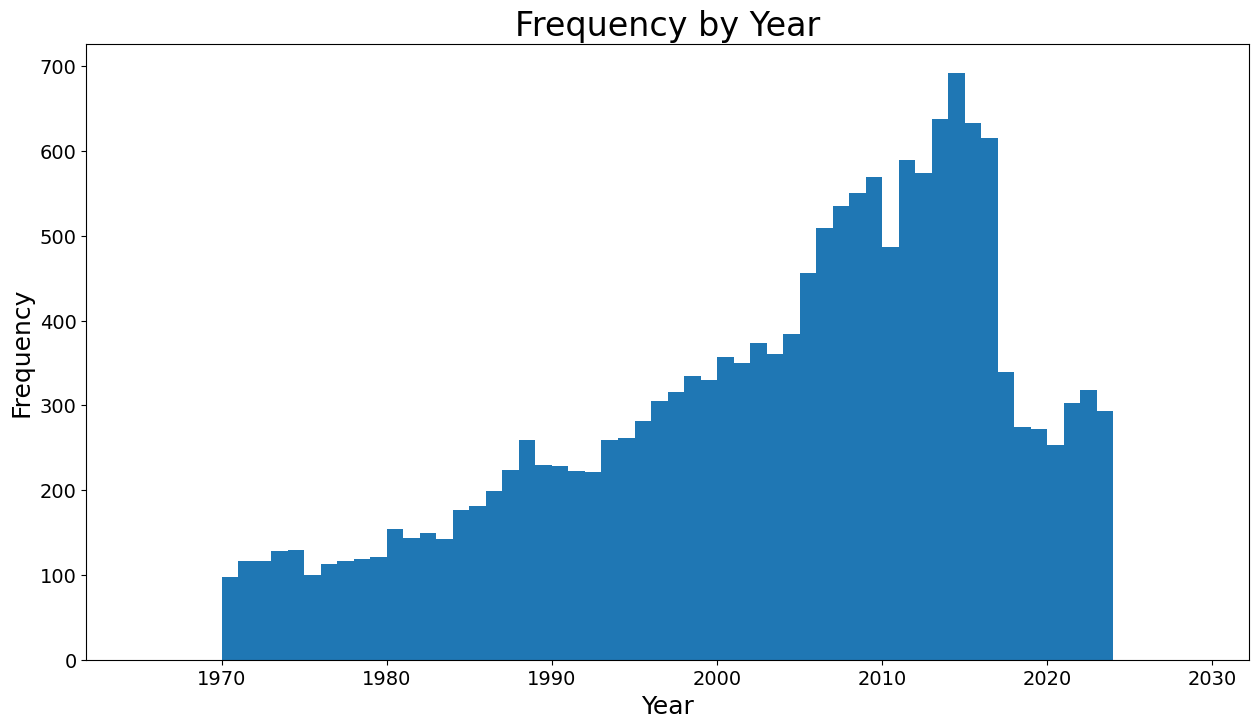

In [ ]:
#Histogram of year
plt.figure(figsize=(15,8))
plt.hist(df.Year, bins=np.arange(1965, 2030))
plt.title('Frequency by Year', fontsize=24)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.savefig('histo_year.jpg', format='jpg', dpi=300)

#### Step 2) Histogram: movie rating systems

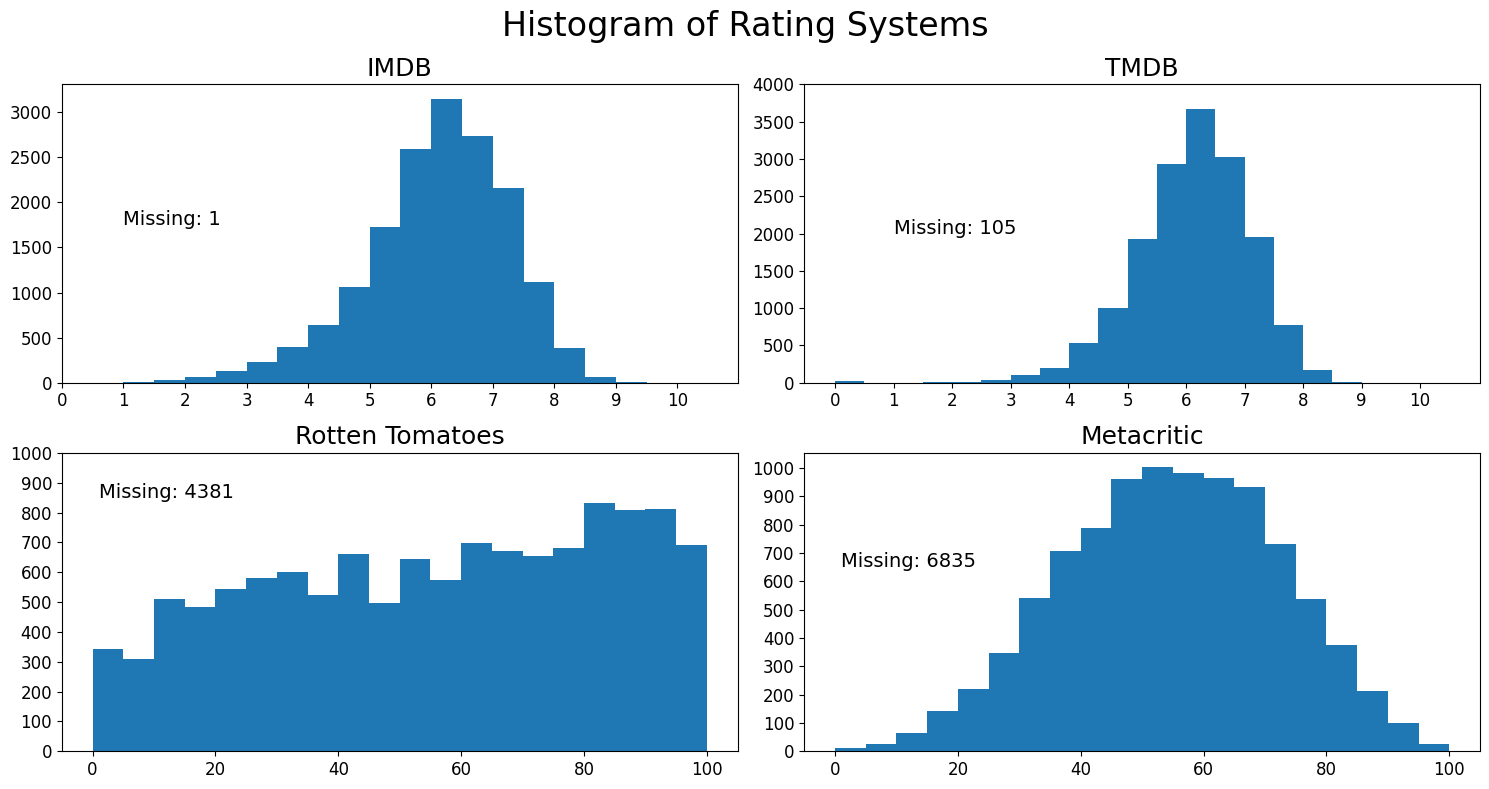

In [ ]:
# Create plot of different rating systems TMDB, IMDB, Rotten Tomatoes, and Metacritic
# Also inserted sum of missing values into each plot

fig, axs = plt.subplots(2, 2, figsize=(15, 8))
tf = 18
fig.suptitle('Histogram of Rating Systems', fontsize=24)

axs[0, 0].hist(df.IMDB, bins=np.arange(1, 11, 0.5))
axs[0, 0].set_title('IMDB', fontsize=tf)
axs[0, 0].text(1, 1750, s = 'Missing: ' + str(df.IMDB.isna().sum()), fontsize=14)
axs[0, 0].set_xticks(np.arange(0, 11, 1))
axs[0, 0].set_xticklabels(np.arange(0, 11, 1), fontsize=12)
axs[0, 0].set_yticks(np.arange(0, 3001, 500))
axs[0, 0].set_yticklabels(np.arange(0, 3001, 500), fontsize=12)

axs[0, 1].hist(df.TMDB, bins=np.arange(0, 11, 0.5))
axs[0, 1].set_title('TMDB', fontsize=tf)
axs[0, 1].text(1, 2000, s = 'Missing: ' + str(df.TMDB.isna().sum()), fontsize=14)
axs[0, 1].set_xticks(np.arange(0, 11, 1))
axs[0, 1].set_xticklabels(np.arange(0, 11, 1), fontsize=12)
axs[0, 1].set_yticks(np.arange(0, 4001, 500))
axs[0, 1].set_yticklabels(np.arange(0, 4001, 500), fontsize=12)

axs[1, 0].hist(df.Rotten_tom, bins=np.arange(0, 101, 5))
axs[1, 0].set_title('Rotten Tomatoes', fontsize=tf)
axs[1, 0].text(1, 850, s = 'Missing: ' + str(df.Rotten_tom.isna().sum()), fontsize=14)
axs[1, 0].set_xticks(np.arange(0, 101, 20))
axs[1, 0].set_xticklabels(np.arange(0, 101, 20), fontsize=12)
axs[1, 0].set_yticks(np.arange(0, 1001, 100))
axs[1, 0].set_yticklabels(np.arange(0, 1001, 100), fontsize=12)

axs[1, 1].hist(df.Metacritic, bins=np.arange(0, 101, 5))
axs[1, 1].set_title('Metacritic', fontsize=tf)
axs[1, 1].text(1, 650, s = 'Missing: ' + str(df.Metacritic.isna().sum()), fontsize=14)
axs[1, 1].set_xticks(np.arange(0, 101, 20))
axs[1, 1].set_xticklabels(np.arange(0, 101, 20), fontsize=12)
axs[1, 1].set_yticks(np.arange(0, 1001, 100))
axs[1, 1].set_yticklabels(np.arange(0, 1001, 100), fontsize=12)

fig.tight_layout()

plt.savefig('histo1.jpg', format='jpg', dpi=300)

plt.show()

#### Step 3) Histogram: Number of IMDB votes cast and box office sales

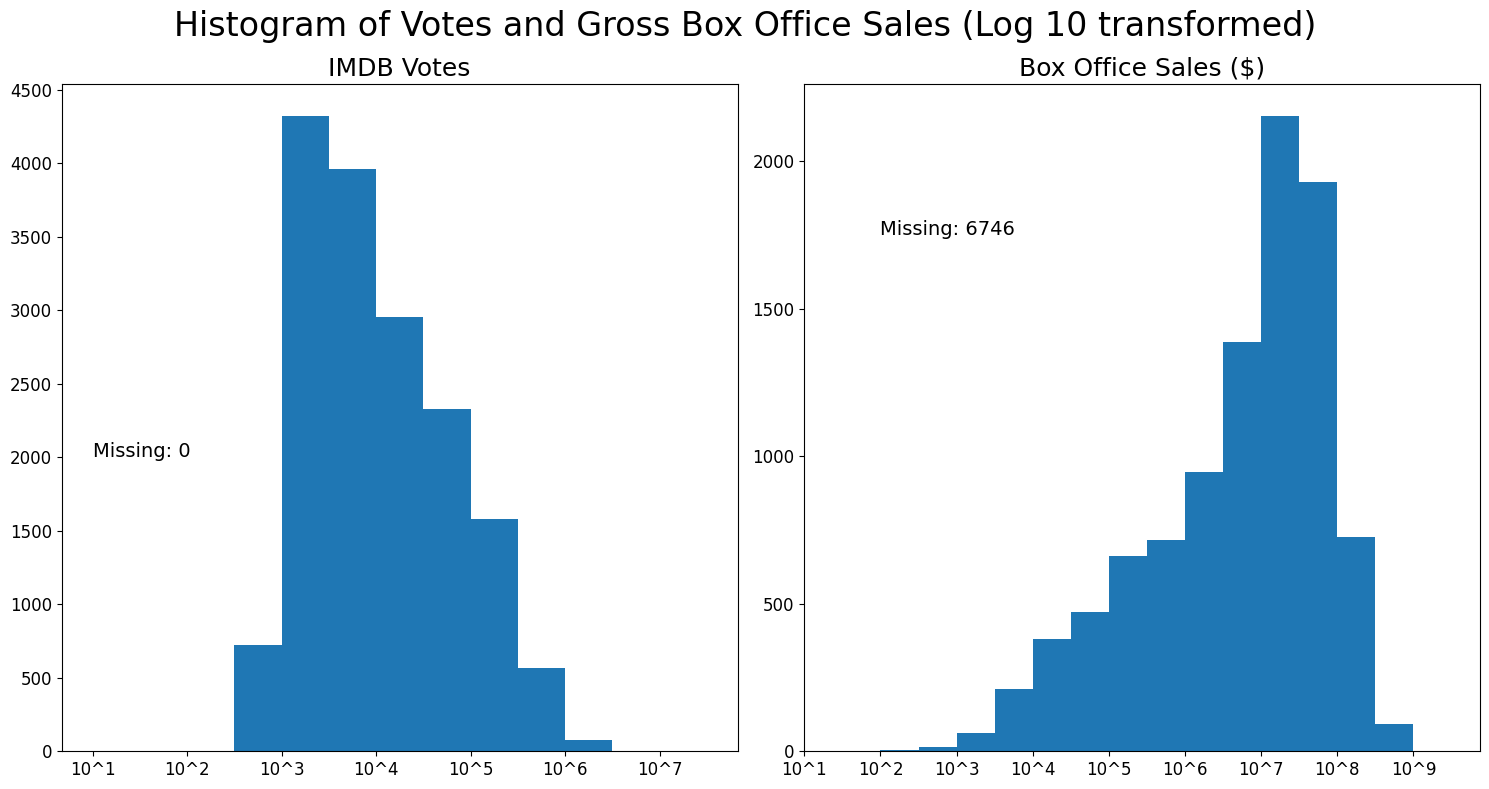

In [ ]:
# Plotted IMDB votes and Gross Domestic Box Office Sales

#Created labels for log transformed graphs
xt = list()
for i in np.arange(1,10,1):
    xt.append('10^' + str(i))

fs = 18
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
fig.suptitle('Histogram of Votes and Gross Box Office Sales (Log 10 transformed)', fontsize=24)

axs[0].hist(np.log10(df.IMDB_votes), bins=np.arange(1, 8, 0.5))
#axs[1, 1].set_aspect('equal', 'box')
axs[0].set_title('IMDB Votes', fontsize=fs)
axs[0].text(1, 2000, s = 'Missing: ' + str(df.IMDB_votes.isna().sum()), fontsize=14)
axs[0].set_xticks(np.arange(1, 8, 1))
axs[0].set_xticklabels(xt[0:7], fontsize=12)
axs[0].set_yticks(np.arange(0, 4501, 500))
axs[0].set_yticklabels(np.arange(0, 4501, 500), fontsize=12)

axs[1].hist(np.log10(df['Gross Domestic Box Office Sales ($)']), bins=np.arange(2, 10, 0.5))
#axs[1, 1].set_aspect('equal', 'box')
axs[1].set_title('Box Office Sales ($)', fontsize=fs)
axs[1].text(2, 1750, s = 'Missing: ' + str(df['Gross Domestic Box Office Sales ($)'].isna().sum()), fontsize=14)
axs[1].set_xticks(np.arange(1, 10, 1))
axs[1].set_xticklabels(xt, fontsize=12)
axs[1].set_yticks(np.arange(0, 2001, 500))
axs[1].set_yticklabels(np.arange(0, 2001, 500), fontsize=12)
#plt.xticks(ticks=[np.log(10**np.arange(1, 9))], labels=[(10**np.arange(1,9)).astype(str)])

fig.tight_layout()

plt.show()

### B. Movie Ratings Versus Time (in years)

#### Step 1) Group movie data by year and then use aggregation to find averages per metric per year.

In [ ]:
# Group by year and find average ratings per metric per year.

df_groupby_year_no_RT = df.groupby("Year").aggregate({
    'IMDB':'mean',
    'Metacritic':'mean',
    'TMDB':'mean'})

df_groupby_year_no_RT = df_groupby_year_no_RT.reset_index()

df_groupby_year_with_RT = df_RT.groupby("Year").aggregate({
    'Rotten Tomatoes': 'mean',
    })

df_groupby_year_with_RT = df_groupby_year_with_RT.reset_index()

In [ ]:
# Add new columns for average ratings of top 10 movies by metric by year to the DataFrames created above.

# Add metrics in metrics1
metrics1 = ['IMDB', 'Metacritic','TMDB']

for metric in metrics1:
    df_top_10 = df.sort_values(by=['Year',metric],ascending=[True,False])
    new_col_name = f'Top 10 {metric} Average'
    top_ten_dict = {}
    for year in range(1970,2024,1):
        top_ten_dict[float(year)] = df_top_10[df_top_10['Year'] == year].head(10)[metric].mean()

    # Create new column listing mean of top 10 movies (by metric) each year.
    df_groupby_year_no_RT.set_index('Year',inplace=True)
    df_groupby_year_no_RT[new_col_name] = pd.Series(top_ten_dict)
    df_groupby_year_no_RT[new_col_name] = df_groupby_year_no_RT[new_col_name].astype(float)
    df_groupby_year_no_RT.reset_index(inplace=True)

# Show final result in DataFrame.
df_groupby_year_no_RT.sample(1)

,Year,IMDB,Metacritic,TMDB,Top 10 IMDB Average,Top 10 Metacritic Average,Top 10 TMDB Average
17,1987.0,6.010714,52.681416,5.954565,7.96,79.5,7.6378


In [ ]:
# Add Rotten Tomatoes columns as well as average ratings of top 10, 20, 30 movies by year.
metrics2 = ['Rotten Tomatoes']

for metric in metrics2:
    df_top = df_RT.sort_values(by=['Year',metric],ascending=[True,False])
    for ten in range(10,40,10):
        new_col_name = f'Top {ten} {metric} Average'
        top_dict = {}
        for year in range(1972,2024,1):
            top_dict[float(year)] = df_top[df_top['Year'] == year].head(ten)[metric].mean()
        df_groupby_year_with_RT.set_index('Year',inplace=True)
        df_groupby_year_with_RT[new_col_name] = pd.Series(top_dict)
        df_groupby_year_with_RT[new_col_name] = df_groupby_year_with_RT[new_col_name].astype(float)
        df_groupby_year_with_RT.reset_index(inplace=True)

# Show final result in DataFrame.
df_groupby_year_with_RT.sample(1)

,Year,Rotten Tomatoes,Top 10 Rotten Tomatoes Average,Top 20 Rotten Tomatoes Average,Top 30 Rotten Tomatoes Average
33,2003.0,57.694517,99.7,97.65,96.466667


#### Step 2) Plot (4) line graphs containing movie ratings per metric as a function of time, in years.

In [ ]:
# Plot average ratings and average ratings of top 10 movies by metric by year.

# Plots ratings in metrics1
for metric in metrics1:
    list = metrics1.copy()
    list.remove(metric)
    df_melt = df_groupby_year_no_RT.drop(list,axis=1)
    df_melt = df_melt.drop([f'Top 10 {list[0]} Average', f'Top 10 {list[1]} Average'],axis=1)
    df_melt = df_melt.melt(id_vars='Year', var_name = metric)
    fig = px.line(
        df_melt,
        x = 'Year',
        y = 'value',
        color = metric,
        title= f'{metric} Ratings over Time (in years)',
        height = 500
    )
    fig.update_layout(title_x = .5)
    fig.show()

# Plots ratings from Rotten Tomatoes
for metric in metrics2:

    df_melt = df_groupby_year_with_RT.melt(id_vars='Year', var_name = metric)
    fig = px.line(
        df_melt,
        x = 'Year',
        y = 'value',
        color = metric,
        title= f'{metric} Ratings over Time (in years)'
    )
    fig.update_layout(title_x = .5)
    fig.show()


### C. Movie Ratings **(by genre)** as a Function of Time (in years).

#### Step 1) Create Table of Ratings by year and genre.


In [ ]:
# Focus on 4 major Genres
i = ['Action', 'Comedy', 'Drama', 'Horror']

# Create columns in table: Year, Ratings, and Genre
columns = ['Year', 'IMDB', 'Metacritic', 'TMDB', 'Rotten_tom', 'Genre']

# Create a blank DataFrame with the specified columns blank_df = pd.DataFrame(columns=columns)
df_gengroupby = pd.DataFrame(columns=columns)

# Loop to aggregate each rating by year separately for each Genre
for i in ['Drama', 'Comedy', 'Action', 'Horror']:
  t = df[df[i]==True]
  t1 = t.groupby('Year').aggregate(
    {'IMDB': 'mean',
     'Metacritic': 'mean',
     'TMDB': 'mean',
     'Rotten_tom': 'mean'
    }
  )
  t1['Genre'] = i
  t1['Year'] = t1.index
  df_gengroupby = pd.concat([df_gengroupby, t1], axis=0, ignore_index=False)

# Sort by Year and Genre and reset index
df_gengroupby = df_gengroupby.sort_values(by=['Year', 'Genre'])
df_gengroupby = df_gengroupby.reset_index(drop=True)

#### Step 2) Plot Movie Ratings by year and genre.


In [ ]:
# Create line plots for 4 rating systems with plotly.express
fig1 = px.line(
    df_gengroupby,
    x = 'Year',
    y = 'IMDB',
    color = 'Genre'
)

fig2 = px.line(
    df_gengroupby,
    x = 'Year',
    y = 'Rotten_tom',
    color = 'Genre',
    labels = {'Rotten_tom': 'Rotten Tomatoes'}
)

fig3 = px.line(
    df_gengroupby,
    x = 'Year',
    y = 'Metacritic',
    color = 'Genre'
)

fig4 = px.line(
    df_gengroupby,
    x = 'Year',
    y = 'TMDB',
    color = 'Genre'
)

# Create 2 x 2 plot with subplots
fig = sp.make_subplots(rows=2, cols=2, subplot_titles=('IMDB ', 'TMDB ', 'Rotten Tomatoes', 'Metacritic'), horizontal_spacing=0.05, vertical_spacing=0.15)

# Place plots and get rid of extra legends
for trace in fig1.data:
  fig.add_trace(trace.update(showlegend=True), row=1, col=1)
for trace in fig4.data:
  fig.add_trace(trace.update(showlegend=False), row=1, col=2)
for trace in fig2.data:
  fig.add_trace(trace.update(showlegend=False), row=2, col=1)
for trace in fig3.data:
  fig.add_trace(trace.update(showlegend=False), row=2, col=2)

# Fix layout
fig.update_layout(height=800,
                  width=1200,
                  title_text="Movie Ratings over Time by Genre",
                  margin=dict(l=0, r=0, t=100, b=10),
                  title_x = 0.5,
                  legend = dict(
                      orientation = "h",
                      yanchor = "bottom",
                      y = -0.1,
                      xanchor = "center",
                      x = 0.5)
                  )

# Insert x-axis labels
fig.update_xaxes(title_text="Year")

fig.show()

### D. Total Gross Domestic Box Office Sales (GDBOS) By Year, Adjusted for Inflation

#### Step 1) Drop all movies that have NaN in GDBOS column.

In [ ]:
df_GDBOS = df.dropna(subset=['Gross Domestic Box Office Sales ($)'])

print(f'A total of {df.shape[0]-df_GDBOS.shape[0]} movies were removed.')

A total of 6746 movies were removed.


#### Step 2) Create dictionary with top 10 GDBOS movies by year and sum those GDBOS values.

In [ ]:
df_GDBOS_sorted = df_GDBOS.sort_values(by=['Year','Gross Domestic Box Office Sales ($)'],ascending=[True,False])

top_ten_dict = {}
for year in range(1972,2024,1):
    top_ten_dict[float(year)] = df_GDBOS_sorted[df_GDBOS_sorted['Year'] == year].head(10)['Gross Domestic Box Office Sales ($)'].sum()

#### Step 3) Group movies by year, and average and sum the GDBOS for each movie in that year.

In [ ]:
# Group movies by year and total GDBOS.
df_GDBOS_by_year = df_GDBOS.groupby('Year')['Gross Domestic Box Office Sales ($)'].sum().reset_index()
print(df_GDBOS_by_year.sample(1))

# Group movies by year and average GDBOS.
df_GDBOS_by_year_avg = df_GDBOS.groupby('Year')['Gross Domestic Box Office Sales ($)'].mean().reset_index()
print(df_GDBOS_by_year_avg.sample(1))

      Year  Gross Domestic Box Office Sales ($)
22  1992.0                         4.489774e+09
      Year  Gross Domestic Box Office Sales ($)
48  2018.0                         5.780835e+07


In [ ]:
# Create new column listing total GDBOS for top 10 movies each year.
df_GDBOS_by_year.set_index('Year',inplace=True)
df_GDBOS_by_year['Gross Domestic Box Office Sales Top 10($)'] = pd.Series(top_ten_dict)
df_GDBOS_by_year['Gross Domestic Box Office Sales Top 10($)'] = df_GDBOS_by_year['Gross Domestic Box Office Sales Top 10($)'].astype(float)
df_GDBOS_by_year.reset_index(inplace=True)

# Show final result in DataFrame.
df_GDBOS_by_year.sample(1)

,Year,Gross Domestic Box Office Sales ($),Gross Domestic Box Office Sales Top 10($)
40,2010.0,9.980373e+09,2.859947e+09


#### Step 4)
- Create functions to calculate inflation and convert USD in given a year to the USD in 2023.
   - Annual inflation rates are from the U.S. Bureau of Labor Statistics at:<br>
   https://data.bls.gov/timeseries/CUUR0000SA0L1E?output_view=pct_12mths
- Apply function to datasets.
- Melt dataset in order to plot DataFrame in a stacked bar graph.

In [ ]:
# Define function to convert the GDBOS for a year and calculate the USD value in year 2023.
ANNUAL_INFLATION_RATES = [3.0, 3.6, 8.3, 9.1, 6.5, 6.3, 7.4, 9.8, 12.4, 10.4, 7.4, 4.0, 5.0, 4.3, 4.0, 4.1, 4.4, 4.5, 5.0, 4.9, 3.7, 3.3, 2.8, 3.0, 2.7, 2.4, 2.3, 2.1, 2.4, 2.6, 2.4, 1.4, 1.8, 2.2, 2.5, 2.3, 2.3, 1.7, 1.0, 1.7, 2.1, 1.8, 1.7, 1.8, 2.2, 1.8, 2.1, 2.2, 1.7, 3.6, 6.2, 4.8]

FIRST_YEAR = 1972
LAST_YEAR = 2023

# Calculates USD in 2023 for total GDBOS.
def get_today_GDBOS(row):

  # Returns USD value in 2023 using the formula T = Pr
  # So, the GDBOS of 2021 would be GDBOS(from 2021)*(1+inflation_rate_2021)*(1+inflation_rate_2022)*(1+inflation_rate_2023).
  # coef = (1+inflation_rate_2021)*(1+inflation_rate_2022)*(1+inflation_rate_2023)
  release_year = row['Year']
  years_elapsed = LAST_YEAR - release_year
  release_year_GDBOS = row['Gross Domestic Box Office Sales ($)']

  # Function calculates coefficient to muliply with release_year_GDBOS
  def calc_coef(rates,i):
      if i != len(rates)-1:
          return ((rates[i]/100.0)+1)*calc_coef(rates,i=i+1)
      else:
          return ((rates[i]/100.0)+1)

  start_index = int(release_year-FIRST_YEAR)
  inflation_rate_list = ANNUAL_INFLATION_RATES[start_index:]
  coef = calc_coef(inflation_rate_list,0)
  return release_year_GDBOS * coef

# Calculates USD in 2023 for top 10 GDBOS movies.
def get_today_GDBOS_top10(row):

  # Returns USD value in 2023 using the formula T = Pr
  # So, the GDBOS of 2021 would be GDBOS(from 2021)*(1+inflation_rate_2021)*(1+inflation_rate_2022)*(1+inflation_rate_2023).
  # coef = (1+inflation_rate_2021)*(1+inflation_rate_2022)*(1+inflation_rate_2023)
  release_year = row['Year']
  years_elapsed = LAST_YEAR - release_year
  release_year_GDBOS = row['Gross Domestic Box Office Sales Top 10($)']

  # Function calculates coefficient to muliply with release_year_GDBOS
  def calc_coef(rates,i):
      if i != len(rates)-1:
          return ((rates[i]/100.0)+1)*calc_coef(rates,i=i+1)
      else:
          return ((rates[i]/100.0)+1)

  start_index = int(release_year-FIRST_YEAR)
  inflation_rate_list = ANNUAL_INFLATION_RATES[start_index:]
  coef = calc_coef(inflation_rate_list,0)
  return release_year_GDBOS * coef

# Apply function to calculate USD value (in 2023) for total GDBOS by year
df_GDBOS_by_year_with_inflation = df_GDBOS_by_year.copy()
df_GDBOS_by_year_with_inflation['Gross Domestic Box Office Sales ($)'] = df_GDBOS_by_year.apply(get_today_GDBOS,axis=1)
df_GDBOS_by_year_with_inflation.rename(columns={'Gross Domestic Box Office Sales ($)': 'Total GDBOS ($ in 2023)'}, inplace=True)


# Apply function to calculate USD value (in 2023) for top 10 GDBOS by year
df_GDBOS_by_year_with_inflation['Gross Domestic Box Office Sales Top 10($)'] = df_GDBOS_by_year_with_inflation.apply(get_today_GDBOS_top10,axis=1)
df_GDBOS_by_year_with_inflation.rename(columns={'Gross Domestic Box Office Sales Top 10($)': 'Total GDBOS Top 10 ($ in 2023)'}, inplace=True)
df_GDBOS_by_year_with_inflation.sample(5)

# Melt the df_GDBOS_by_year_with_inflation DataFrame to allow a stacked bar graph and convert values to billions ($) and round to (2) decimals.
df_melted = df_GDBOS_by_year_with_inflation.melt(id_vars='Year', var_name = 'GDBOS')
df_melted['value'] = df_melted['value'].apply(lambda value: round(value/1000000000,1))

df_melted.sample(5)

,Year,GDBOS,value
46,2016.0,Total GDBOS ($ in 2023),14.5
9,1979.0,Total GDBOS ($ in 2023),8.5
103,2019.0,Total GDBOS Top 10 ($ in 2023),5.6
70,1986.0,Total GDBOS Top 10 ($ in 2023),2.8
58,1974.0,Total GDBOS Top 10 ($ in 2023),4.3


In [ ]:
# Calculate average GDBOS by year, adjusted for inflation through year 2023.

df_GDBOS_by_year_avg['Gross Domestic Box Office Sales ($)'] = df_GDBOS_by_year_avg.apply(get_today_GDBOS, axis=1)
df_GDBOS_by_year_avg['Gross Domestic Box Office Sales ($)'] = df_GDBOS_by_year_avg['Gross Domestic Box Office Sales ($)'].apply(lambda sales: round(sales/1000000,1))
df_GDBOS_by_year_avg.rename(columns={'Gross Domestic Box Office Sales ($)': 'Avg GDBOS ($ in 2023)'}, inplace=True)

#### Step 5) Plot bar graph displaying total GDBOS by year, adjusted for inflation through year 2023.

In [ ]:
# Create stacked bar graph displaying the total GDBOS by year and GDBOS for top 10 movies by year, adjusted for inflation through year 2023.
fig = px.bar(
    df_melted,
    x = 'Year',
    y = 'value',
    color='GDBOS',
    title = 'GDBOS by Year, Adjusted for Inflation (Billions $ in 2023)',
    barmode='overlay',
    text='value',
)

fig.update_traces(textfont=dict(size=12))

fig.update_layout(
    width = 1200,
    height=600,
    legend=dict(
        x=0,
        y=-.1,
        xanchor='left',
        yanchor='top'
    )
)
fig.add_annotation(
    x=2020,
    y=5.5,
    text="COVID-19 & Streaming Service Surge",
    showarrow=True,
    arrowhead=2,
    xanchor='right',
    yanchor='bottom',
    font=dict(size=8, color="white"),
    bgcolor="black"
)
fig.show()

#### Step 6) Plot line graph displaying average GDBOS by year, adjusted for inflation through year 2023.

### E. What Years had the "Best Movies"
#### We have looked at what years were best for the average movies, but what years were the most great movies made?

In [ ]:

#Calculating  Medians, standard deviations, maxes and graphing them

#Establish the year range
years = range(1977,2015)
median_IMDb = df['IMDB'].median()
std_IMDB = df['IMDB'].std()


df_yearly = pd.DataFrame(years, columns = ['Year'])
imdb_arr, rt_arr, mc_arr, tmdb_arr = [], [], [], []
imdb_med, rt_med, mc_med, tmdb_med = [], [], [], []
imdb_std, rt_std, mc_std, tmdb_std = [], [], [], []

#RT was a string, converting it to float in place
df['Rotten Tomatoes'] = pd.to_numeric(df['Rotten Tomatoes'])
print(df['Rotten Tomatoes'].head(10))
for i in years:
    imdb_arr.append(df[df['Year'] == i]['IMDB'].max())
    imdb_med.append(df[df['Year'] == i]['IMDB'].mean())
    imdb_std.append(df[df['Year'] == i]['IMDB'].std())


    rt_arr.append(df[df['Year'] == i]['Rotten Tomatoes'].max()/10)
    rt_med.append(df[df['Year'] == i]['Rotten Tomatoes'].mean()/10)
    rt_std.append(df[df['Year'] == i]['Rotten Tomatoes'].std()/10)


    mc_arr.append(df[df['Year'] == i]['Metacritic'].max()/10)
    mc_med.append(df[df['Year'] == i]['Metacritic'].mean()/10)
    mc_std.append(df[df['Year'] == i]['Metacritic'].std()/10)


    tmdb_arr.append(df[df['Year'] == i]['TMDB'].max())
    tmdb_med.append(df[df['Year'] == i]['TMDB'].mean())
    tmdb_std.append(df[df['Year'] == i]['TMDB'].std())

data_max = {'Year':years, 'IMDB':imdb_arr, 'Metacritic': mc_arr, 'TMDB': tmdb_arr, 'Rotten Tomatoes': rt_arr}


print(median_IMDb)
print(median_IMDb + 3* std_IMDB)
df_max = pd.DataFrame(data_max)

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
5     62.0
6    100.0
7      5.0
8      NaN
9      NaN
Name: Rotten Tomatoes, dtype: float64
6.2
9.667519728562954


In [ ]:
#What do the 2.0 Z-scores look like? (2 standard deviations out)
print(np.array(imdb_med) + 2*np.array(imdb_std))
print(np.array(rt_med) + 2*np.array(rt_std))
print(np.array(mc_med) + 2*np.array(mc_std))
print(np.array(tmdb_med) + 2*np.array(tmdb_std))

[8.34114437 8.46467489 8.52206032 8.25329816 8.24461663 8.27919363
 8.39018457 8.31788644 8.25977041 8.0057504  8.28426778 8.13885628
 8.1822847  8.02375659 8.08358675 8.31031111 8.34033124 8.24195344
 8.41615553 8.21171418 8.21267094 8.29916307 8.56908131 8.44121378
 8.35205979 8.33204932 8.53607595 8.45314642 8.45052388 8.472428
 8.51386083 8.55014406 8.45215635 8.49307384 8.52850722 8.51153071
 8.47123816 8.43269543]
[11.39705146 11.30145694 12.11944756 10.9948877  11.22104093 11.90290588
 11.71059098 11.71910203 11.21425587 11.06519972 11.02411656 10.99424697
 10.87686118 10.97526752 10.6932855  11.00562788 10.93444788 10.34159024
 10.64674264 10.60814722 10.45785293 10.23835821 10.53817084 10.44152613
 10.35832272 10.69955374 10.56410217 10.58328659 10.42011675 10.3283856
 11.0509761  10.61380914 10.55216642 10.80333772 11.34610049 11.2501842
 11.14126461 11.31875235]
[9.18123614 9.40444781 9.49151085 9.31353863 8.79093883 9.33501474
 8.99636791 8.92828616 8.80831829 8.7487066  8.

In [ ]:
#What were the top scoring movies each year, graphed over time
fig5 = px.line(
    df_max.reset_index(),
    x = 'Year',
    y = ['IMDB', 'TMDB', 'Metacritic', 'Rotten Tomatoes'],
    title='Top Yearly Rating'
)
fig5.show()

In [ ]:
data_med = {'Year':years, 'IMDB':imdb_med, 'Metacritic': mc_med, 'TMDB': tmdb_med, 'Rotten Tomatoes': rt_med}

df_med = pd.DataFrame(data_med)

fig6 = px.line(
    df_med.reset_index(),
    x = 'Year',
    y = ['IMDB', 'TMDB', 'Metacritic', 'Rotten Tomatoes'],
    title='Median Yearly Rating'
)
fig6.show()

In [ ]:
df.head()

,Title,Year,Genre(s),IMDB,Rotten Tomatoes,Metacritic,TMDB,# of IMDB Votes,# of Awards,Gross Domestic Box Office Sales ($),...,Horror,Music,Mystery,Romance,Sci-Fi,Thriller,Other Genre,Year_int,filmyear,filmyear2
0,#1 Cheerleader Camp,2010.0,Comedy,3.7,NaN,NaN,4.800,"2,983",NaN,NaN,...,False,False,False,False,False,False,0,2010,#1 Cheerleader Camp_2010,1cheerleadercamp2010
1,#Horror,2015.0,"Crime, Drama, Horror",3.1,NaN,42.0,3.600,"4,062",NaN,NaN,...,True,False,False,False,False,False,0,2015,#Horror_2015,horror2015
2,#Realityhigh,2017.0,"Comedy, Drama, Romance",5.1,NaN,NaN,6.291,"7,009",NaN,NaN,...,False,False,False,True,False,False,0,2017,#Realityhigh_2017,realityhigh2017
3,$5 a Day,2008.0,"Comedy, Drama",6.3,NaN,NaN,5.600,"3,691",NaN,NaN,...,False,False,False,False,False,False,0,2008,$5 a Day_2008,5aday2008
4,$50K and a Call Girl: A Love Story,2014.0,"Action, Adventure, Comedy",6.4,NaN,NaN,5.900,"2,184",NaN,NaN,...,False,False,False,False,False,False,0,2014,$50K and a Call Girl: A Love Story_2014,50kandacallgirlalovestory2014


In [ ]:
df_count_imdb = []
df_count_imdb =df['IMDB'].copy().value_counts()

In [ ]:
fig = px.histogram(df, 'IMDB')
fig.update_layout(xaxis_title="IMDB Rating",yaxis_title="# of movies")
fig.show()

In [ ]:
fig = px.histogram(df, 'TMDB')
#fig.update_layout(bargap=0.2)
fig.show()

In [ ]:
fig = px.histogram(df, 'Metacritic')
fig.show()

In [ ]:
#Determine the Z score of the IMDB values of each movie in the data set
df['IMDB Zscore'] = (df['IMDB'] - df['IMDB'].mean()) / df['IMDB'].std()
df['TMDB Zscore'] = (df['TMDB'] - df['TMDB'].mean()) / df['TMDB'].std()
df['Metacritic Zscore'] = (df['Metacritic'] - df['Metacritic'].mean()) / df['Metacritic'].std()
#See which movies have a z-score of 2, and which years have the most
df_great_IMDB = df[df['IMDB Zscore']>2].copy()
df_great_TMDB = df[df['TMDB Zscore']>2].copy()
df_great_metacritic = df[df['Metacritic Zscore']>2].copy()

In [ ]:
fig = px.histogram(df_great_IMDB, x="Year", labels = {'Year': 'year','count':'Number of Great Movies'}, title = 'Great Movies per 5 Years (according to IMDB)')
fig.update_layout(bargap=0.2)
fig.update_layout(yaxis_title="Number of Great Movies Released")
fig.show()

In [ ]:
fig = px.histogram(df_great_TMDB, x="Year", labels = {'Year': 'year','count':'Number of Great Movies'}, title = 'Great Movies per 5 Years')
fig.update_layout(bargap=0.2)
fig.update_layout(yaxis_title="Number of Great Movies Released")
fig.show()

In [ ]:
fig = px.histogram(df_great_metacritic, x="Year", labels = {'Year': 'year','count':'Number of Great Movies'}, title = 'Great Movies per 5 Years')
fig.update_layout(bargap=0.2)
fig.update_layout(yaxis_title="Number of Great Movies Released")
fig.show()

### F. Evaluating Movie Ratings over time by Oscar Award Status

####Data quality check (DO NOT SHOW)

In [ ]:
#Summarize Oscar nominations and wins by year
award_temp = df_final.groupby('Year')[['wins', 'nominations', 'big5win', 'big5nom']].sum()
#Avoid double counting wins and nominations
award_temp.nominations = award_temp.nominations - award_temp.wins
award_temp.big5nom = award_temp.big5nom - award_temp.big5win

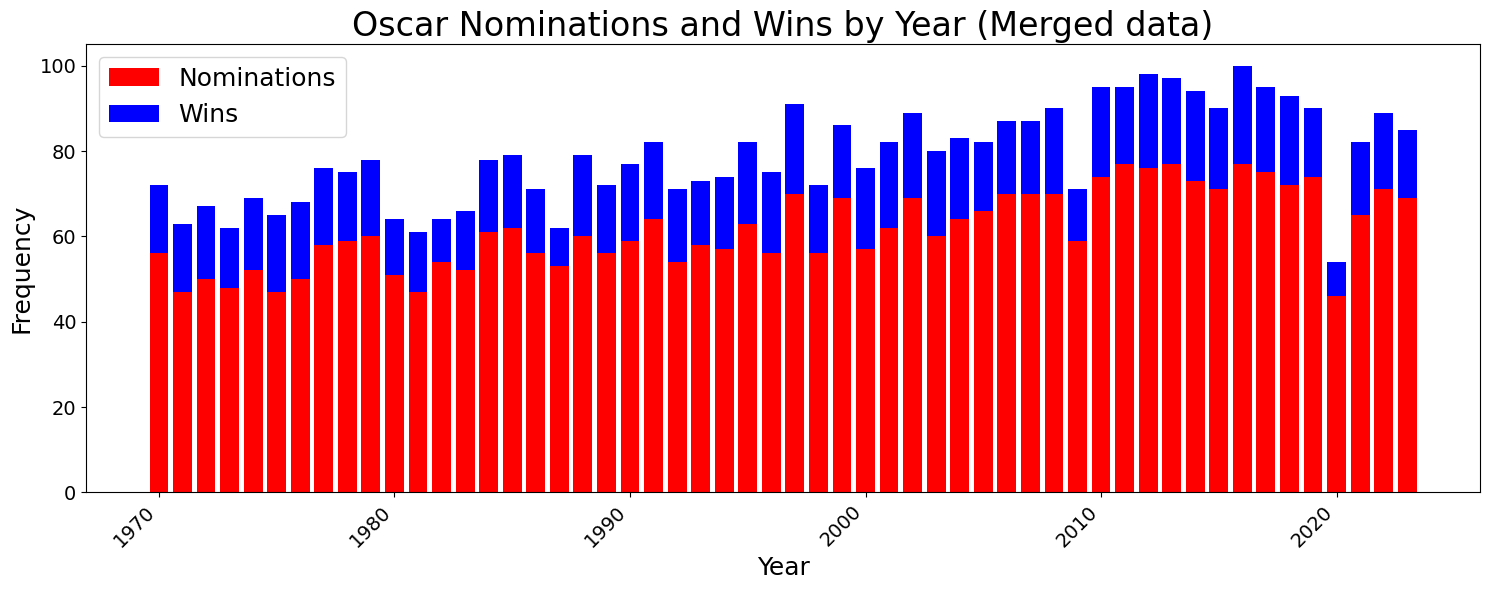

In [ ]:
# Bar graph of wins/nominations by year
plt.figure(figsize=(15, 6))
plt.bar(award_temp.index, award_temp.nominations, color='r', label='Nominations')
plt.bar(award_temp.index, award_temp.wins, bottom=award_temp.nominations, color='b', label='Wins')
plt.yticks(fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.title('Oscar Nominations and Wins by Year (Merged data)', fontsize=24)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.legend(loc="upper left", fontsize=18)
plt.tight_layout()
plt.savefig('bar stacked Oscar by year_merged.jpg', format='jpg', dpi=300, bbox_inches='tight')

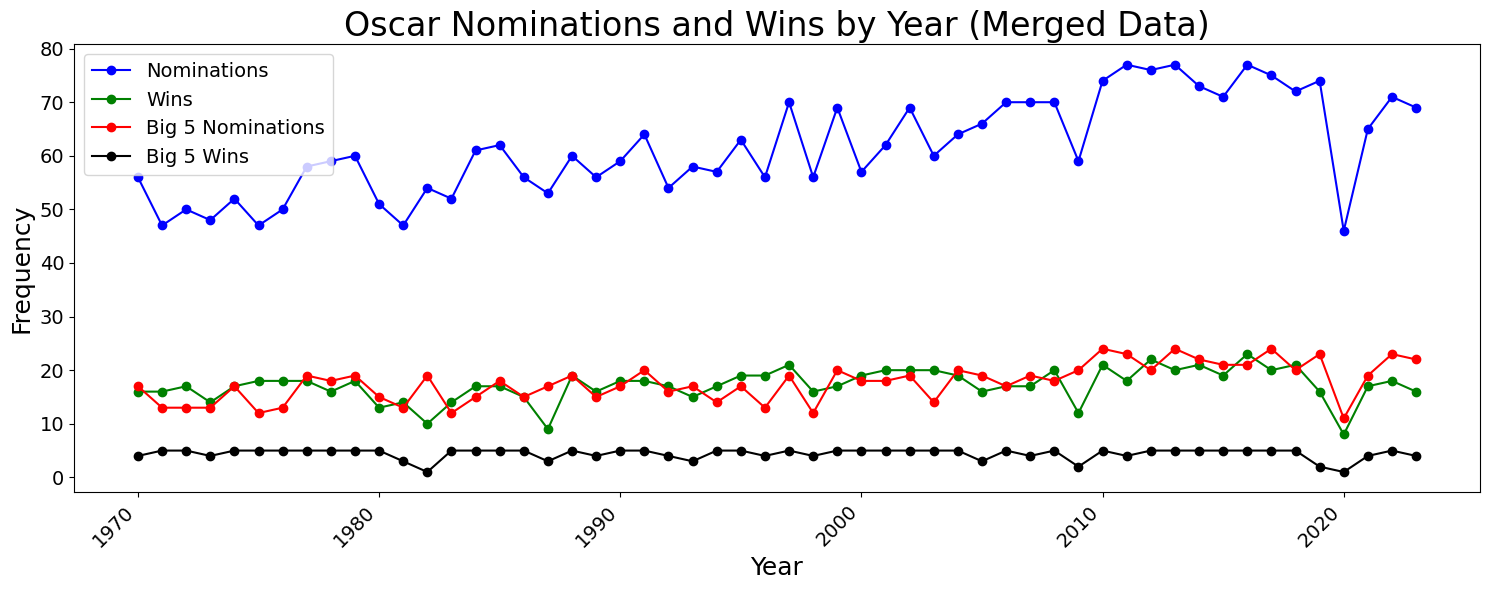

In [ ]:
#Line graph of Wins/Nominations and Big 5 Wins/Nominations by Year
plt.figure(figsize=(15, 6))
plt.plot(award_temp.index, award_temp.nominations, marker = 'o', color='blue', label='Nominations')
plt.plot(award_temp.index, award_temp.wins, marker = 'o', color='green', label='Wins')
plt.plot(award_temp.index, award_temp.big5nom, marker = 'o', color='red', label='Big 5 Nominations')
plt.plot(award_temp.index, award_temp.big5win, marker = 'o', color='black', label='Big 5 Wins')
#plt.bar(award_temp.index, award_temp.wins, bottom=award_temp.nominations, color='b', label='Wins')
plt.yticks(fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.title('Oscar Nominations and Wins by Year (Merged Data)', fontsize=24)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.tight_layout()
plt.savefig('line graph oscars by year_merged.jpg', format='jpg', dpi=300, bbox_inches='tight')

###Create Tables of movie ratings by year with 5 groups: All movies and those with at least 1 Oscar nomination, Oscar win, Big 5 nomination, and Big 5 win

In [ ]:
#IMDB Ratings
tab1 = df_final[df_final.nominations>0].groupby('Year').aggregate('IMDB').mean()
tab2 = df_final[df_final.wins>0].groupby('Year').aggregate('IMDB').mean()
tab3 = df_final[df_final.big5nom>0].groupby('Year').aggregate('IMDB').mean()
tab4 = df_final[df_final.big5win>0].groupby('Year').aggregate('IMDB').mean()
tab5 = df_final.groupby('Year').aggregate('IMDB').mean()

tab_IMDB = pd.concat([tab5, tab1, tab2, tab3, tab4], axis=1)
tab_IMDB.columns = ['All Movies', 'Oscar Nomination', 'Oscar Win', 'Big 5 Nomination', 'Big 5 Win']

#TMDB Ratings
tab1 = df_final[df_final.nominations>0].groupby('Year').aggregate('TMDB').mean()
tab2 = df_final[df_final.wins>0].groupby('Year').aggregate('TMDB').mean()
tab3 = df_final[df_final.big5nom>0].groupby('Year').aggregate('TMDB').mean()
tab4 = df_final[df_final.big5win>0].groupby('Year').aggregate('TMDB').mean()
tab5 = df_final.groupby('Year').aggregate('TMDB').mean()

tab_TMDB = pd.concat([tab5, tab1, tab2, tab3, tab4], axis=1)
tab_TMDB.columns = ['All Movies', 'Oscar Nomination', 'Oscar Win', 'Big 5 Nomination', 'Big 5 Win']

#Rotten Tomatoe Ratings
tab1 = df_final[df_final.nominations>0].groupby('Year').aggregate('Rotten_tom').mean()
tab2 = df_final[df_final.wins>0].groupby('Year').aggregate('Rotten_tom').mean()
tab3 = df_final[df_final.big5nom>0].groupby('Year').aggregate('Rotten_tom').mean()
tab4 = df_final[df_final.big5win>0].groupby('Year').aggregate('Rotten_tom').mean()
tab5 = df_final.groupby('Year').aggregate('Rotten_tom').mean()

tab_RT = pd.concat([tab5, tab1, tab2, tab3, tab4], axis=1)
tab_RT.columns = ['All Movies', 'Oscar Nomination', 'Oscar Win', 'Big 5 Nomination', 'Big 5 Win']

#Metacritic Ratings
tab1 = df_final[df_final.nominations>0].groupby('Year').aggregate('Metacritic').mean()
tab2 = df_final[df_final.wins>0].groupby('Year').aggregate('Metacritic').mean()
tab3 = df_final[df_final.big5nom>0].groupby('Year').aggregate('Metacritic').mean()
tab4 = df_final[df_final.big5win>0].groupby('Year').aggregate('Metacritic').mean()
tab5 = df_final.groupby('Year').aggregate('Metacritic').mean()

tab_Meta = pd.concat([tab5, tab1, tab2, tab3, tab4], axis=1)
tab_Meta.columns = ['All Movies', 'Oscar Nomination', 'Oscar Win', 'Big 5 Nomination', 'Big 5 Win']

#### Create plots showing mean rating by year for 4 different ratings systems. Each plot has 5 groups: All movies and those with at least 1 Oscar nomination, Oscar win, Big 5 nomination, and Big 5 win

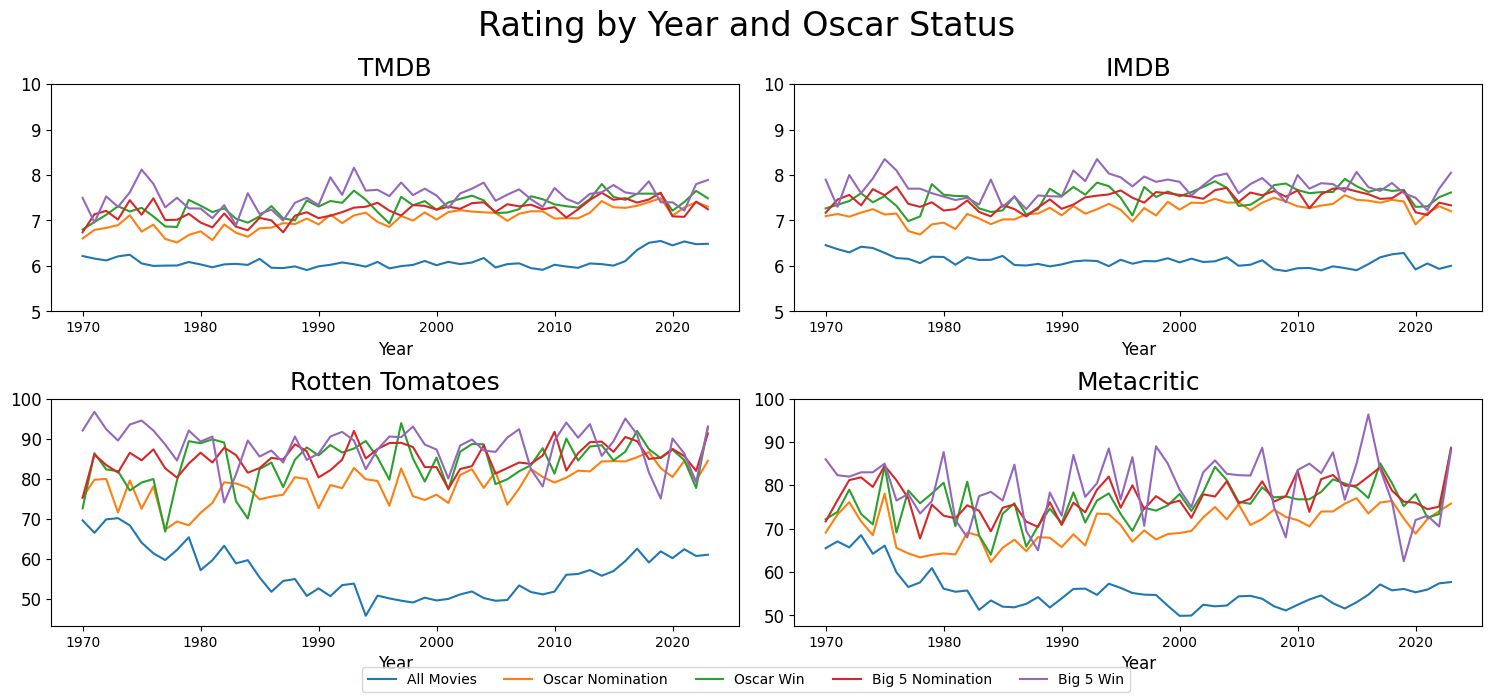

In [ ]:
# Create plot of different rating systems TMDB, IMDB, Rotten Tomatoes, and Metacritic

fig, axs = plt.subplots(2, 2, figsize=(15, 7))
tf = 18
fig.suptitle('Rating by Year and Oscar Status', fontsize=24)


axs[0, 0].plot(tab_TMDB)
axs[0, 0].set_title('TMDB', fontsize=tf)
#axs[0, 0].set_xticks(np.arange(0, 11, 1))
#axs[0, 0].set_xticklabels(np.arange(0, 11, 1), fontsize=12)
axs[0, 0].set_yticks(np.arange(5, 11, 1))
axs[0, 0].set_yticklabels(np.arange(5, 11, 1), fontsize=12)
axs[0, 0].set_xlabel('Year', fontsize=12)

axs[0, 1].plot(tab_IMDB)
axs[0, 1].set_title('IMDB', fontsize=tf)
axs[0, 1].set_yticks(np.arange(5, 11, 1))
axs[0, 1].set_yticklabels(np.arange(5, 11, 1), fontsize=12)
axs[0, 1].set_xlabel('Year', fontsize=12)

axs[1, 0].plot(tab_RT)
axs[1, 0].set_title('Rotten Tomatoes', fontsize=tf)
axs[1, 0].set_yticks(np.arange(50, 101, 10))
axs[1, 0].set_yticklabels(np.arange(50, 101, 10), fontsize=12)
axs[1, 0].set_xlabel('Year', fontsize=12)

axs[1, 1].plot(tab_Meta)
axs[1, 1].set_title('Metacritic', fontsize=tf)
axs[1, 1].set_yticks(np.arange(50, 101, 10))
axs[1, 1].set_yticklabels(np.arange(50, 101, 10), fontsize=12)
axs[1, 1].set_xlabel('Year', fontsize=12)

fig.legend(tab_TMDB, loc='lower center', ncol=5)
#plt.tight_layout()
plt.tight_layout(pad=1)
plt.subplots_adjust(bottom=0.1)
plt.show()

#Brian's Playground

In [ ]:
AIR = [6.3, 4.7, 3.0, 3.6, 8.3, 9.1, 6.5, 6.3, 7.4, 9.8, 12.4, 10.4, 7.4, 4.0, 5.0, 4.3, 4.0, 4.1, 4.4, 4.5, 5.0, 4.9, 3.7, 3.3, 2.8, 3.0, 2.7, 2.4, 2.3, 2.1, 2.4, 2.6, 2.4, 1.4, 1.8, 2.2, 2.5, 2.3, 2.3, 1.7, 1.0, 1.7, 2.1, 1.8, 1.7, 1.8, 2.2, 1.8, 2.1, 2.2, 1.7, 3.6, 6.2, 4.8]
# from https://data.bls.gov/pdq/SurveyOutputServlet
def calc_inf(year):
    if year == 2023:
        return 1
    else:
        return ((1 + AIR[54-(2023-year)]/100)*calc_inf(year+1))

In [ ]:
df_final['Year_int'] = df_final['Year'].astype(int)
df_final['GDBOS_adj'] = df_final.apply(lambda row: row['Gross Domestic Box Office Sales ($)']*calc_inf(row['Year_int']), axis=1)
df_final['GDBOS_adj_log'] = np.log10(df_final['GDBOS_adj'])
df_final['IMDB_votes_log'] = np.log10(df_final['IMDB_votes'])
df_final['Decade'] = df_final['Year'].apply(lambda year: str(year)[:3] + '0s')

In [ ]:
df_lin = df_final[['Year_int', 'IMDB', 'TMDB', 'Rotten_tom', 'Metacritic', 'IMDB_votes_log', 'GDBOS_adj_log', 'GDBOS_adj', 'wins', 'nominations', 'big5nom', 'big5win']].copy()

<Axes: >

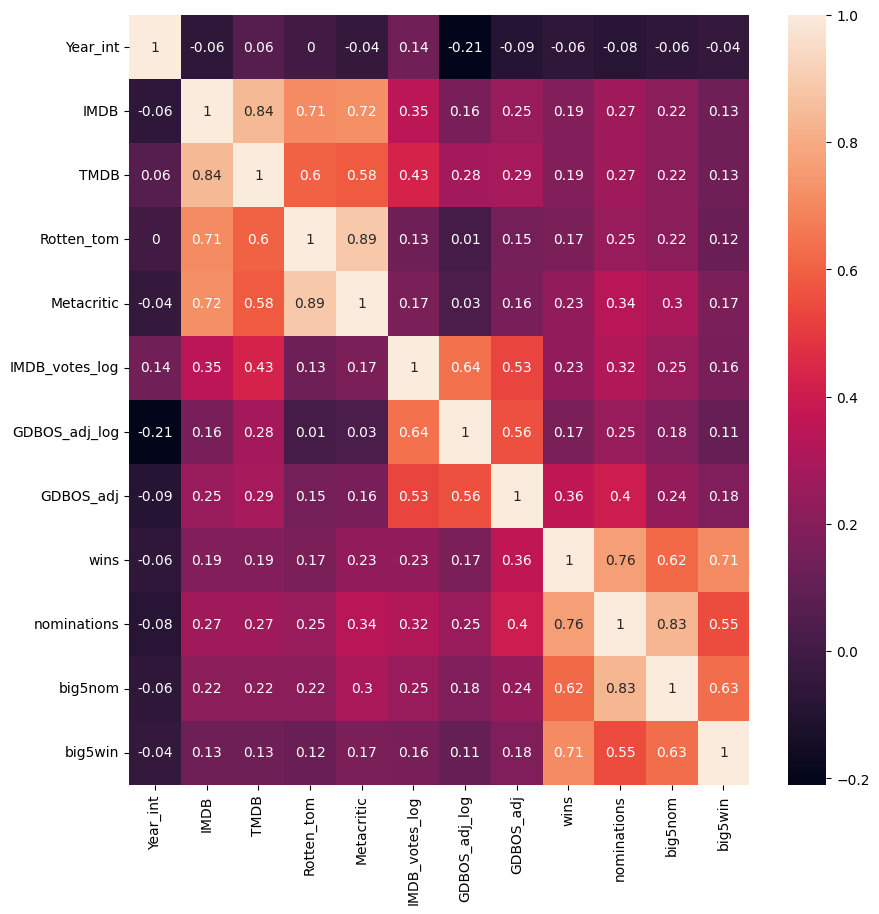

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

correlation_matrix = df_lin.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True, ax=ax)

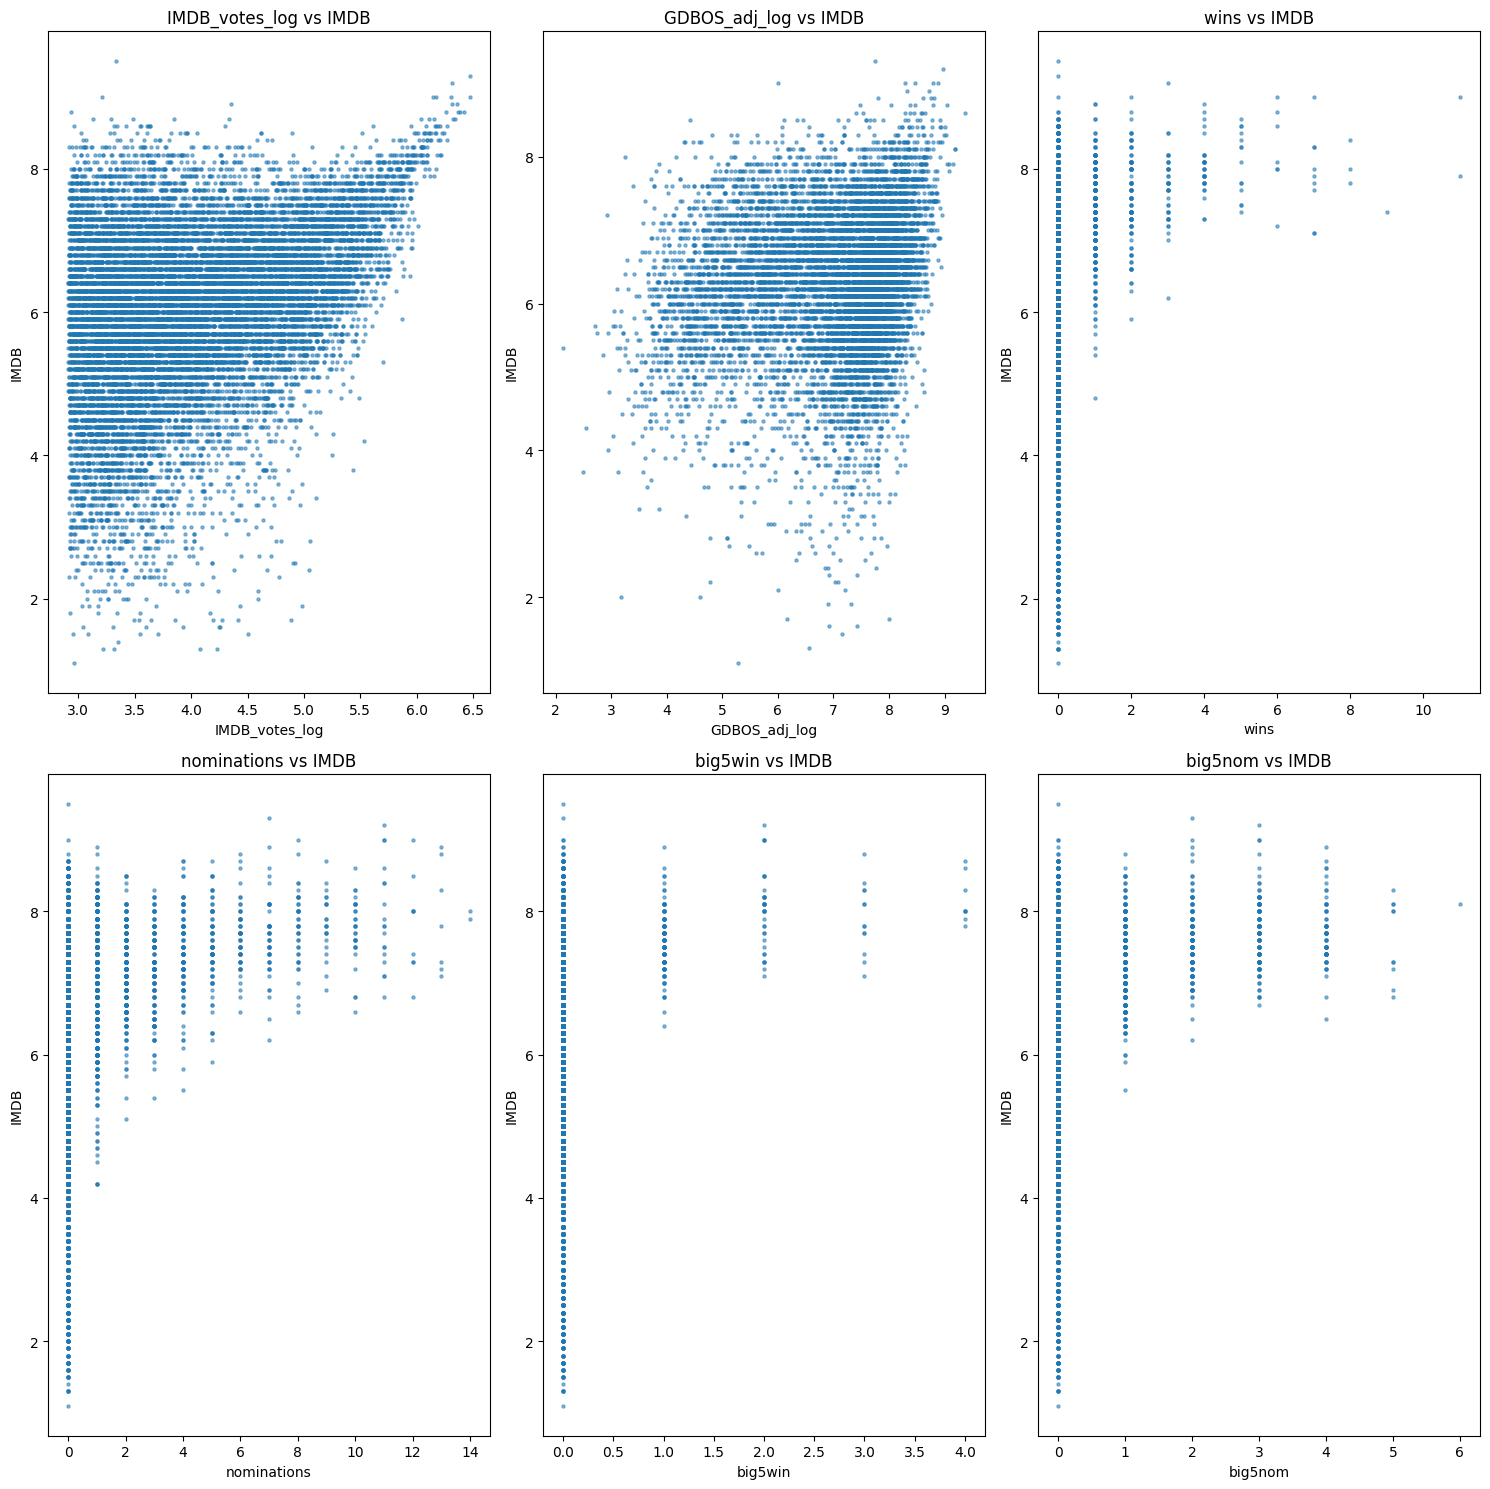

In [ ]:
# Define features and target
features = ['IMDB_votes_log', 'GDBOS_adj_log', 'wins', 'nominations', 'big5win', 'big5nom']
target = df_lin['IMDB']

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))

# Plot each feature against the target
for i, feature in enumerate(features):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.scatter(df_lin[feature], target, alpha=0.5, s=5)
    ax.set_title(f'{feature} vs IMDB')
    ax.set_xlabel(feature)
    ax.set_ylabel('IMDB')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
tab1 = df_final.groupby('Decade').aggregate('IMDB').mean()
tab2 = df_final.groupby('Decade').aggregate('TMDB').mean()
tab3 = df_final.groupby('Decade').aggregate('Rotten_tom').mean()
tab4 = df_final.groupby('Decade').aggregate('Metacritic').mean()
tab_dec_it = pd.concat([tab1, tab2], axis=1)
tab_dec_rm = pd.concat([tab3, tab4], axis=1)

In [ ]:
tab_dec_it['Decade'] = tab_dec_it.index
tab_dec_rm['Decade'] = tab_dec_rm.index

tab_dec2 = tab_dec_it.melt(id_vars='Decade', var_name='Rating System', value_name='Rating')
tab_dec3 = tab_dec_rm.melt(id_vars='Decade', var_name='Rating System', value_name='Rating')

In [ ]:
fig = px.bar(tab_dec2, x='Decade', y='Rating', color='Rating System', barmode='group', title='Movie Ratings by Decade and Source')
fig.show()

In [ ]:
fig = px.bar(tab_dec3, x='Decade', y='Rating', color='Rating System', barmode='group', title='Movie Ratings by Decade and Source')
fig.show()

In [ ]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
fit = ols('Metacritic ~ Decade', data=df_final).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:             Metacritic   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     32.50
Date:                Thu, 05 Dec 2024   Prob (F-statistic):           5.60e-33
Time:                        01:49:22   Log-Likelihood:                -41292.
No. Observations:                9668   AIC:                         8.260e+04
Df Residuals:                    9662   BIC:                         8.264e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          62.6478      0.793     

In [ ]:
tab = pd.concat([fit.params, fit.conf_int(), fit.pvalues], axis=1).round(3)
tab.columns = ['coef', 'lower', 'upper', 'p']
tab

,coef,lower,upper,p
Intercept,62.648,61.093,64.203,0.0
Decade[T.1980s],-9.342,-11.226,-7.457,0.0
Decade[T.1990s],-7.789,-9.599,-5.978,0.0
Decade[T.2000s],-10.221,-11.908,-8.535,0.0
Decade[T.2010s],-8.697,-10.363,-7.031,0.0
Decade[T.2020s],-6.154,-8.086,-4.222,0.0


# CONCLUSION

### <u>Average Ratings by Year</u>
- TMDB displayed **significant bias** towards modern movies versus movies released prior to 2015.

- Trends:
  - The best-rated periods include the following:
    - 1970’s
    - 1978-1984
    - 1993-1994
    - 2013-2019
  - The worst-rated periods include the following:
    - Late 1980’s
    - 1990’s
    - 2000’s

### <u>Gross Domestic Box Office Sales (GDBOS)</u>
#### Total GDBOS
- Obvious **upward trend** throughout data analyzed until 2020.

#### Top 10 GDBOS Movies by Year
- **Significant years**:
  - **1977 (Star Wars: Episode IV - A New Hope)**,
  - 1978 (Grease),
  - 1980 (Star Wars: Episode V - The Empire Strikes Back),
  - 1994 (The Lion King)
  - 1997 (Men in Black)
  - 2009 (Transformers: Revenge of the Fallen),
  - 2012 (The Avengers),
  - 2015 (Jurassic World),
  - 2019 (Avengers: Endgame)<br>
<br>
- **1990’s and 2000’s** experienced an overall **'dip'** with a few years as exceptions.


# SUMMARY

- Undoubtedly, the **late 1970's** produced exceptional movies.
- In general, the quality of movies, when viewed from multiple angles, appears to **go up and down**.  
  - **"Rosy retrospection"** may explain why we believe cinema in general created better movies, when some time periods made worse movies.  
    - For instance, we remember the best movies from each decade and associate these movies with "that" decade and forget the "bad" movies.
